**Let's tackle the dataset number 2 videos_commented_daily.parquet:  which contains the number of videos commented by users per day with the date**

In [4]:
import pandas as pd
# Load the Parquet file
file_path = 'data/videos_commented_daily.parquet'
data = pd.read_parquet(file_path)
data.head()

,author,videos_commented,upload_date
0,1695,10,2018-04-21
1,1695,10,2018-04-28
2,1695,10,2018-05-12
3,1695,10,2018-05-15
4,1695,11,2018-05-17


**Let's investigate : How many videos do "bots" comment each day across time to detect trends** so over the whole year 2018 we want the number of comments made by bots and  the number of comment/bots that commented that day

In [5]:
import pandas as pd


# Group by upload_date and aggregate
result = data.groupby('upload_date').agg(videos_commented=('videos_commented', 'sum'),distinct_bots=('author', 'nunique')).reset_index()

# Calculate comments per bot
result['comments_per_bot'] = result['videos_commented'] / result['distinct_bots']
result.head()


,upload_date,videos_commented,distinct_bots,comments_per_bot
0,2018-01-01,6788,548,12.386861
1,2018-01-02,12018,973,12.351490
2,2018-01-03,13573,1052,12.902091
3,2018-01-04,14417,1144,12.602273
4,2018-01-05,14046,1130,12.430088


In [6]:
# Check the total number of distinct bots in the original dataset
total_distinct_bots = data['author'].nunique()
print("Total number of distinct bots:", total_distinct_bots)

Total number of distinct bots: 119906


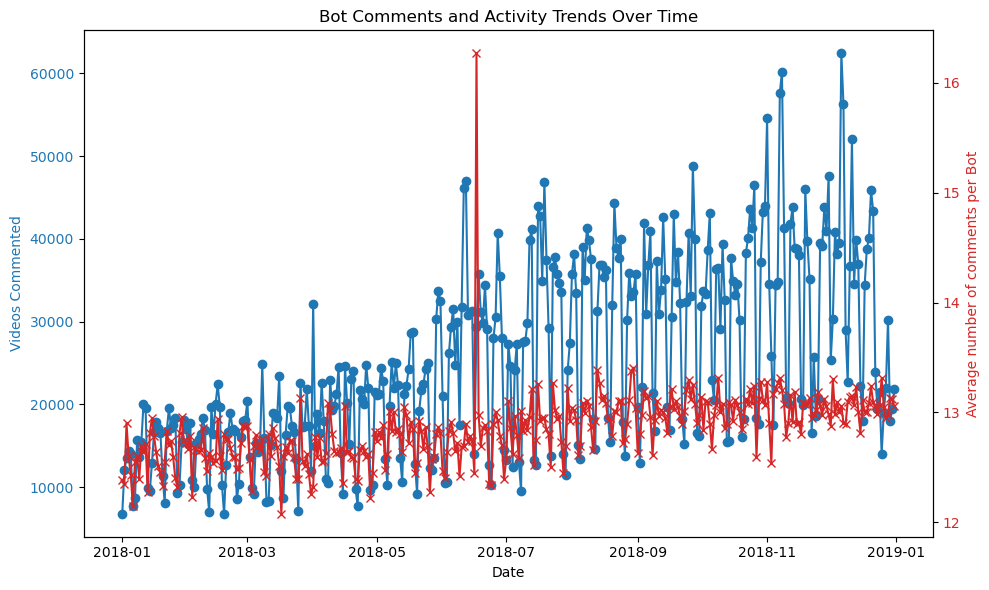

In [7]:
import matplotlib.pyplot as plt

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot videos commented
ax1.plot(result['upload_date'], result['videos_commented'], color='tab:blue', label='Videos Commented', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Videos Commented', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis to plot comments per bot
ax2 = ax1.twinx()
ax2.plot(result['upload_date'], result['comments_per_bot'], color='tab:red', label='Comments per Bot', marker='x')
ax2.set_ylabel('Average number of comments per Bot', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout adjustments
plt.title('Bot Comments and Activity Trends Over Time')
fig.tight_layout()  # Adjust layout to fit everything
plt.xticks(rotation=45)

# Show the plot
plt.show()


From this first graph we see that the amounts of comments made by suspicious users increased during the year 2018. 

Note that in june there is an outlier in terms of comments per bot, let's investigate that. 

In [9]:
# Find the date of the outlier (assuming highest value is the outlier)
outlier_date = result.loc[result['comments_per_bot'].idxmax(), 'upload_date']

print("Outlier date:", outlier_date)

Outlier date: 2018-06-17


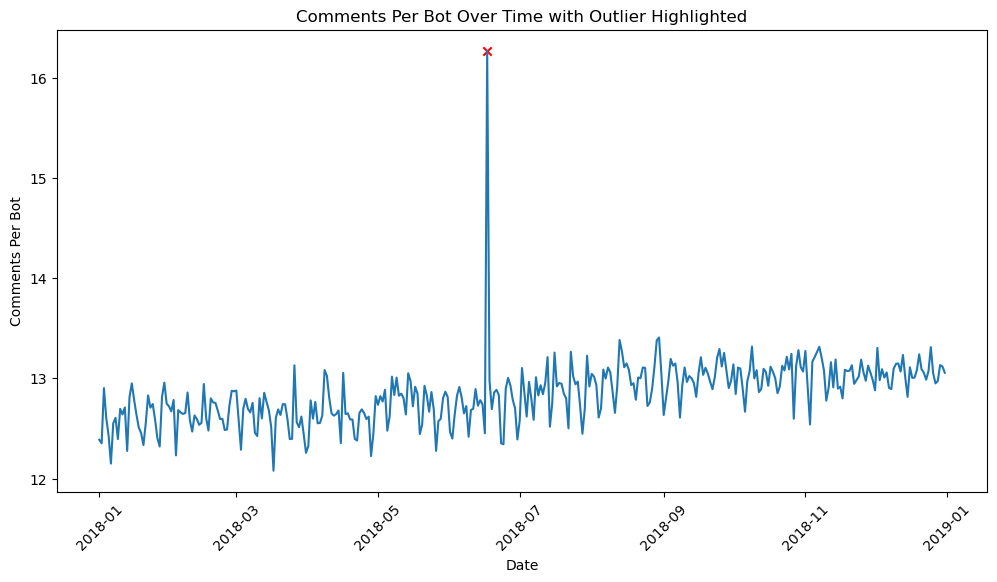

In [10]:
# Visualize comments per bot over time, highlighting the outlier
plt.figure(figsize=(12, 6))
plt.plot(result['upload_date'], result['comments_per_bot'])
plt.scatter(outlier_date, result.loc[result['upload_date'] == outlier_date, 'comments_per_bot'], color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Comments Per Bot')
plt.title('Comments Per Bot Over Time with Outlier Highlighted')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Filter data for the outlier date
outlier_data = data[data['upload_date'] == outlier_date]

# 1. Total comments
total_comments = outlier_data['videos_commented'].sum()
print("Total comments on the outlier date:", total_comments)

# 2. Average comments per user
avg_comments_per_user = outlier_data['videos_commented'].mean()
print("Average comments per user on the outlier date:", avg_comments_per_user)

# 3. Top commenter
top_commenter = outlier_data.loc[outlier_data['videos_commented'].idxmax()]
print("Top commenter:")
print(top_commenter)




Total comments on the outlier date: 29333
Average comments per user on the outlier date: 16.268996117581807
Top commenter:
author               428983453
videos_commented           125
upload_date         2018-06-17
Name: 525686, dtype: object


In [12]:
outlier_data.describe()

,author,videos_commented
count,1.803000e+03,1803.000000
mean,2.883433e+08,16.268996
std,1.647800e+08,10.188417
min,6.870800e+04,10.000000
25%,1.456438e+08,11.000000
50%,2.915844e+08,13.000000
75%,4.284674e+08,17.500000
max,5.758451e+08,125.000000


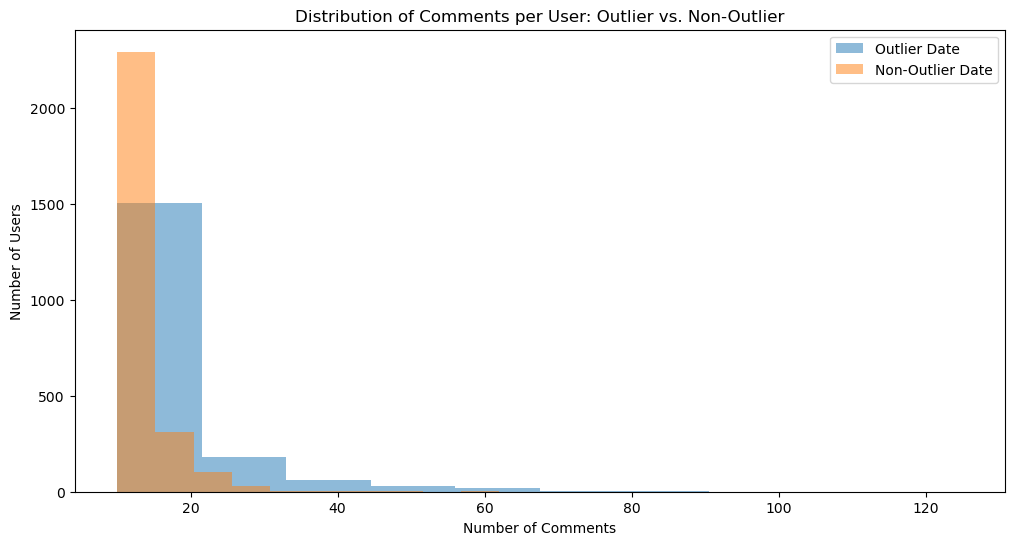

Total comments on the outlier date: 29333
Average comments per user on the outlier date: 16.268996117581807
Total comments on the non-outlier date: 35766
Average comments per user on the non-outlier date: 12.977503628447025


In [13]:
# Get the day after the outlier date
non_outlier_date = outlier_date + pd.Timedelta(days=1)

# Filter data for the day after the outlier date
non_outlier_data = data[data['upload_date'] == non_outlier_date]



# Calculate statistics for the non-outlier date
total_comments_non_outlier = non_outlier_data['videos_commented'].sum()
avg_comments_per_user_non_outlier = non_outlier_data['videos_commented'].mean()

# Plot histograms for both outlier and non-outlier days
plt.figure(figsize=(12, 6))
plt.hist(outlier_data['videos_commented'], bins=10, alpha=0.5, label='Outlier Date')
plt.hist(non_outlier_data['videos_commented'], bins=10, alpha=0.5, label='Non-Outlier Date')
plt.xlabel('Number of Comments')
plt.ylabel('Number of Users')
plt.title('Distribution of Comments per User: Outlier vs. Non-Outlier')
plt.legend()
plt.show()

print("Total comments on the outlier date:", total_comments)
print("Average comments per user on the outlier date:", avg_comments_per_user)
print("Total comments on the non-outlier date:", total_comments_non_outlier)
print("Average comments per user on the non-outlier date:", avg_comments_per_user_non_outlier)

The outlier day is here compared with the day right after in order to avoid being biased by the constant increase of 'number of comments per bots' and the 'total number of comments that day' metrics over the year as seen in the first graph showing the trends. 

From the comparison of these histograms we can say that the number of bots commenting around 10 to 20 comments is lower compared to a normal day. However the bots commented on much more videos that day! It is a very strange phenomenon and we haven't found why yet. It could be a coordinated bot attack. 

Now let's see the difference using box plots too. 

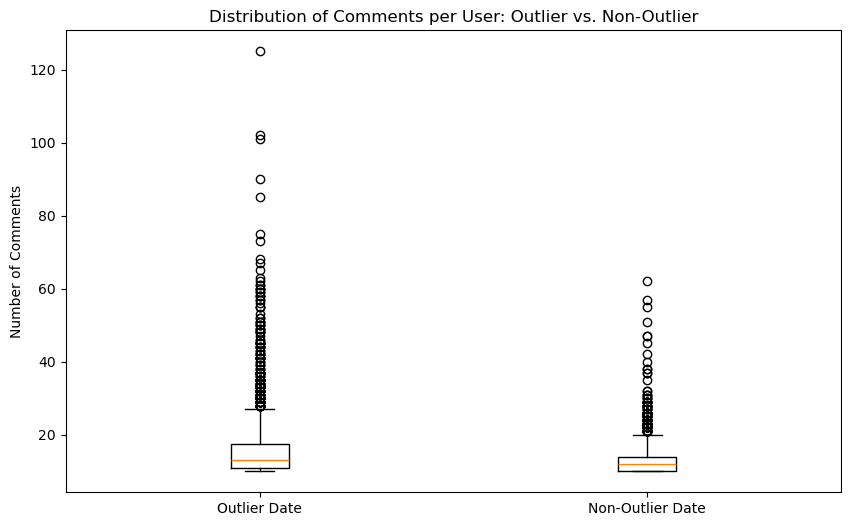

In [14]:

plt.figure(figsize=(10, 6))
plt.boxplot([outlier_data['videos_commented'], non_outlier_data['videos_commented']], labels=['Outlier Date', 'Non-Outlier Date'])
plt.ylabel('Number of Comments')
plt.title('Distribution of Comments per User: Outlier vs. Non-Outlier')
plt.show()

We see that there more outliers on the right box plot but also they have a much higher number of comments as well. The max is one that commented on 125 different channels!

Now let's get back to trends in the total number of comments and number of comments per bots. 
We will study it now on a weekly, and then monthly basis to have less noisy data and get clearer trends.

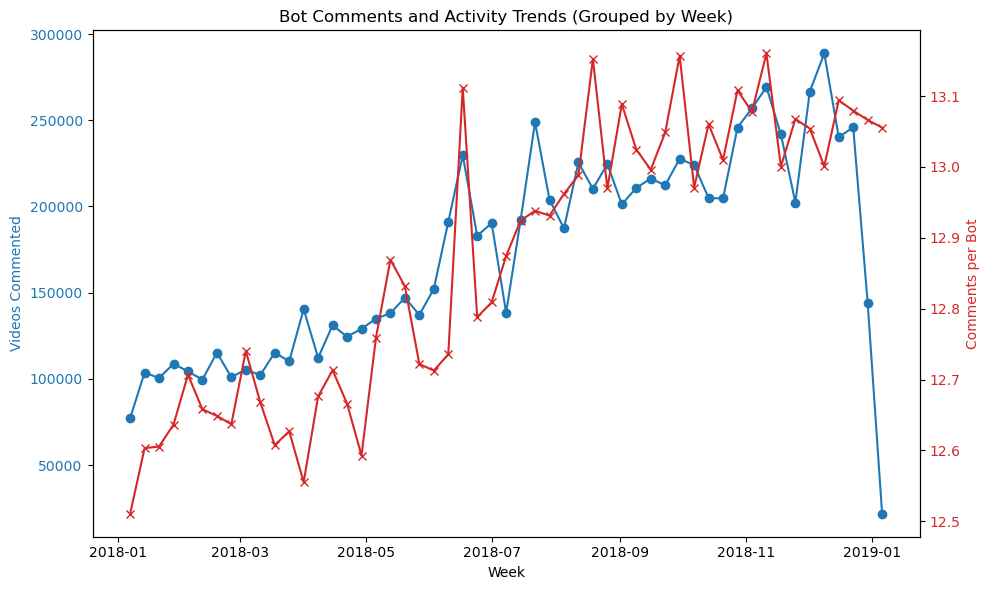

In [15]:
# Ensure 'upload_date' is in datetime format
result['upload_date'] = pd.to_datetime(result['upload_date'])

# Group by week
result_weekly = result.groupby(pd.Grouper(key='upload_date', freq='W')).agg(
    videos_commented=('videos_commented', 'sum'),
    distinct_bots=('distinct_bots', 'sum')  # Use sum for distinct_bots
).reset_index()

# Calculate comments per bot per week
result_weekly['comments_per_bot'] = result_weekly['videos_commented'] / result_weekly['distinct_bots']

# Plot the weekly data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot videos commented per week
ax1.plot(result_weekly['upload_date'], result_weekly['videos_commented'], color='tab:blue', label='Videos Commented (Weekly)', marker='o')
ax1.set_xlabel('Week')
ax1.set_ylabel('Videos Commented', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis to plot comments per bot per week
ax2 = ax1.twinx()
ax2.plot(result_weekly['upload_date'], result_weekly['comments_per_bot'], color='tab:red', label='Comments per Bot (Weekly)', marker='x')
ax2.set_ylabel('Comments per Bot', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout adjustments
plt.title('Bot Comments and Activity Trends (Grouped by Week)')
fig.tight_layout()  # Adjust layout to fit everything
plt.xticks(rotation=45)

# Show the plot
plt.show()

We get confirmation of the trend in a clearer way. Both the number of videos commented by suspicious users and the avaerage number of videos commented by suspicious users increased. 

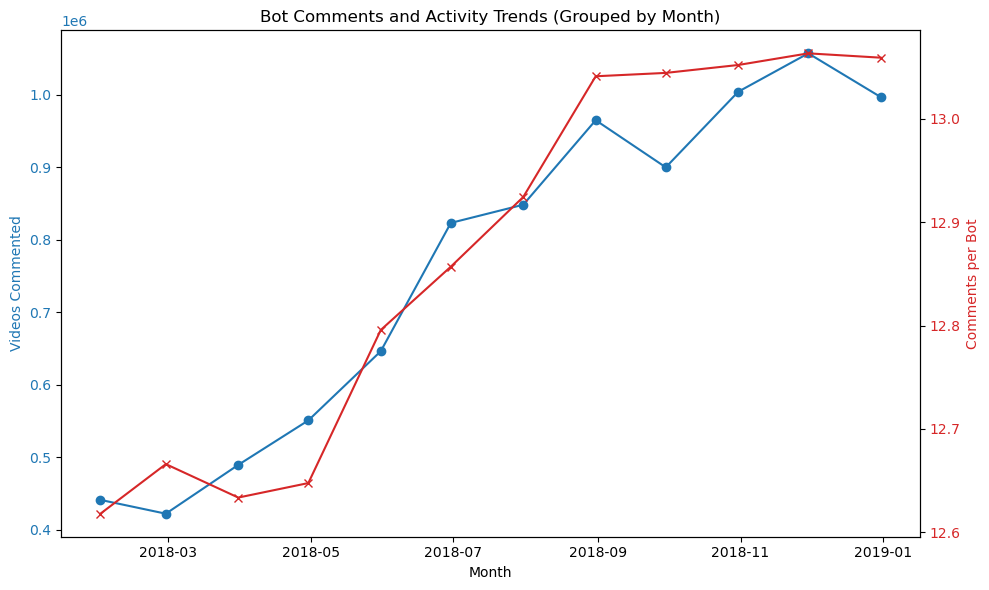

In [16]:
# Group by month
result_monthly = result.groupby(pd.Grouper(key='upload_date', freq='M')).agg(
    videos_commented=('videos_commented', 'sum'),
    distinct_bots=('distinct_bots', 'sum')  # Use sum for distinct_bots
).reset_index()

# Calculate comments per bot per month
result_monthly['comments_per_bot'] = result_monthly['videos_commented'] / result_monthly['distinct_bots']

# Plot the monthly data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot videos commented per month
ax1.plot(result_monthly['upload_date'], result_monthly['videos_commented'], color='tab:blue', label='Videos Commented (Monthly)', marker='o')
ax1.set_xlabel('Month')
ax1.set_ylabel('Videos Commented', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis to plot comments per bot per month
ax2 = ax1.twinx()
ax2.plot(result_monthly['upload_date'], result_monthly['comments_per_bot'], color='tab:red', label='Comments per Bot (Monthly)', marker='x')
ax2.set_ylabel('Comments per Bot', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout adjustments
plt.title('Bot Comments and Activity Trends (Grouped by Month)')
fig.tight_layout()  # Adjust layout to fit everything
plt.xticks(rotation=45)

# Show the plot
plt.show()

With the monthly segmented plot, we've managed to reduce the "noise" caused by daily and weekly variations. This has made the underlying trends clearer.

***To be explored for part 3 of the project :***

Next steps:

*Weekday Analysis:*
Investigate if there's a significant difference in the number of comments made by suspicious users on different weekdays.
This could reveal patterns in their activity, such as increased activity on weekends or specific weekdays.

*Date-Specific Analysis:*
Identify specific dates with unusually high or low suspicious user activity.
Correlate these dates with any significant real-world events or trends, especially those relevant to the English-speaking world.
Consider using a calendar of major events in 2018 to find potential connections.


***Analyzing Bot Lifetime Based on Commenting Frequency***

In this part  of the analysis, we aim to understand the typical "lifetime" of bots—how long they remain active in terms of commenting—before they stop commenting altogether. Specifically, we’ll explore:

Bot Activity Duration:

*Lifetime Definition*: We define a bot’s lifetime as the number of days it remains active in commenting. We’ll analyze the duration from a bot’s first recorded comment to its last known activity.



count    119906.000000
mean         52.699339
std          88.530296
min           1.000000
25%           1.000000
50%           1.000000
75%          68.000000
max         365.000000
Name: lifetime_days, dtype: float64


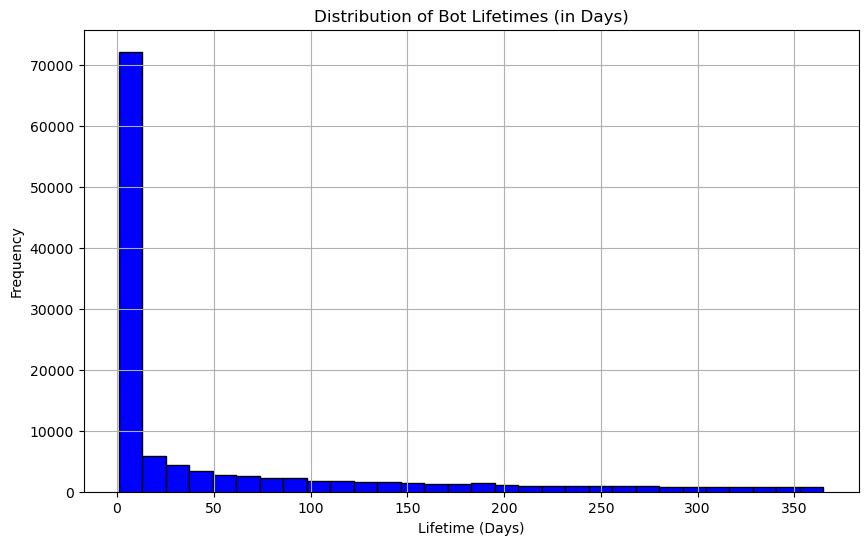

In [19]:
# BOT ACTIVITY DURATION
#adjust to the right format 

data['upload_date'] = pd.to_datetime(data['upload_date'])
# Identify the first and last comment date for each bot
bot_activity = data.groupby('author')['upload_date'].agg(['min', 'max'])

# Calculate the lifetime of each bot (in days)
bot_activity['lifetime_days'] = (bot_activity['max'] - bot_activity['min']).dt.days +1

# Display the lifetime distribution
print(bot_activity['lifetime_days'].describe())

#Plot the distribution of bot lifetimes
plt.figure(figsize=(10, 6))
plt.hist(bot_activity['lifetime_days'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Bot Lifetimes (in Days)')
plt.xlabel('Lifetime (Days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Better way to visualize: segmenting by categories:**

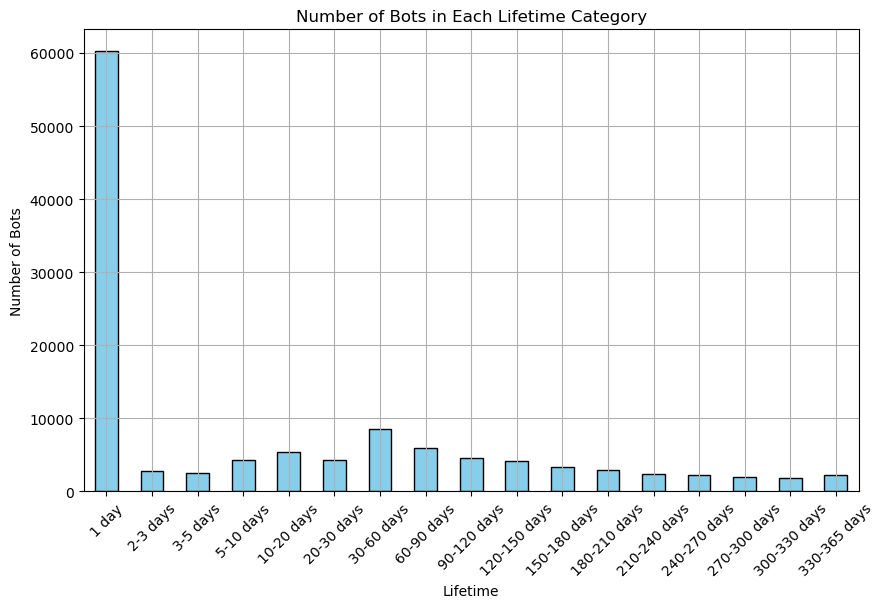

Counts of bots in each lifetime category:
lifetime_category
1 day           60227
2-3 days         2741
3-5 days         2573
5-10 days        4318
10-20 days       5443
20-30 days       4285
30-60 days       8596
60-90 days       5881
90-120 days      4536
120-150 days     4172
150-180 days     3321
180-210 days     2931
210-240 days     2434
240-270 days     2296
270-300 days     1982
300-330 days     1839
330-365 days     2274
Name: count, dtype: int64
percentage of bots per lifetimes categories:
lifetime_category
1 day           50.252401
2-3 days         2.287045
3-5 days         2.146868
5-10 days        3.602867
10-20 days       4.541548
20-30 days       3.575332
30-60 days       7.172359
60-90 days       4.907008
90-120 days      3.784762
120-150 days     3.481047
150-180 days     2.770987
180-210 days     2.445577
210-240 days     2.030889
240-270 days     1.915744
270-300 days     1.653748
300-330 days     1.534431
330-365 days     1.897388
Name: count, dtype: float64


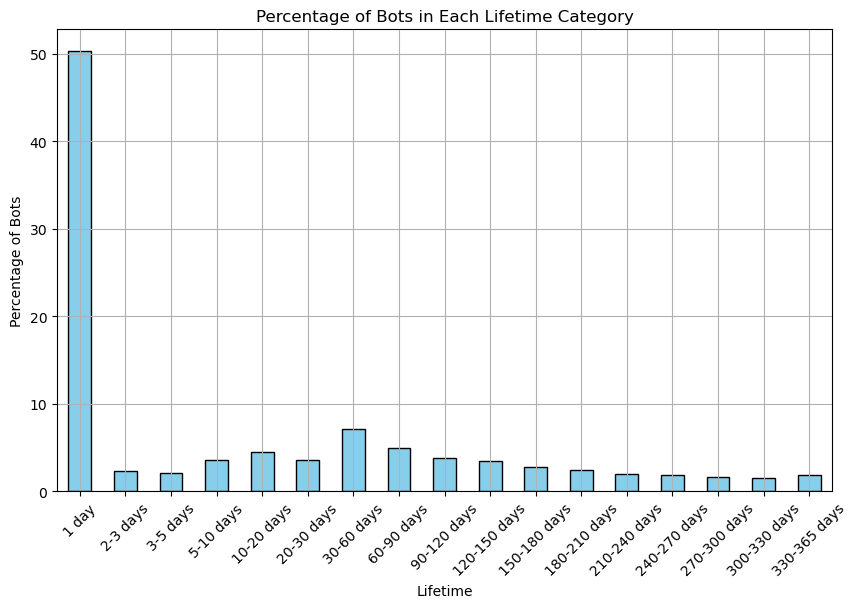

In [45]:
#Define the bins for bot lifetimes
bins = [1,2, 3, 5, 10, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
labels = ['1 day','2-3 days', '3-5 days', '5-10 days', '10-20 days', '20-30 days', 
          '30-60 days', '60-90 days', '90-120 days', '120-150 days', '150-180 days', 
          '180-210 days', '210-240 days', '240-270 days', '270-300 days', '300-330 days', 
          '330-365 days']

# Categorize bots based on their lifetime
bot_activity['lifetime_category'] = pd.cut(bot_activity['lifetime_days'], bins=bins, labels=labels, right=False)

# Count the number of bots in each lifetime category
lifetime_counts = bot_activity['lifetime_category'].value_counts().sort_index()

# Plot the counts of bots in each lifetime category
plt.figure(figsize=(10, 6))
lifetime_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Bots in Each Lifetime Category')
plt.xlabel('Lifetime')
plt.ylabel('Number of Bots')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Print the counts for each category
print("Counts of bots in each lifetime category:")
print(lifetime_counts)

print("percentage of bots per lifetimes categories:")
pourcentages_of_lifetime_categories= (lifetime_counts / lifetime_counts.sum()*100)
print(pourcentages_of_lifetime_categories)

plt.figure(figsize=(10, 6))
pourcentages_of_lifetime_categories.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage of Bots in Each Lifetime Category')
plt.xlabel('Lifetime')
plt.ylabel('Percentage of Bots')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

We can conclude that 50% of users we considered bots are just commenting on 10 different videos(which was the filter condition)during 1 day on the data from 2018, maybe they are still active the rest of the year but they were not considered "suspicious" the rest of the time by our filter. 

***This raises few hypothesis that we need to further investigate during the rest of the Project:***
1) Are they really bots or just a normal user that was really active over the course of 1 day ? 
2) Were these bots that were patched ? 


Now we want to investigate the relation between having a given "lifetime" with respect to the number of comments per day. (We remind you that here in this dataset we created, we only have the days were the author wrote more or equal to 10 comments). 

**Influence of Commenting Frequency on Lifetime**:

*Average Daily Comments*: We’ll group bots based on their average number of comments per day. By segmenting bots by this metric, we can determine if higher daily commenting activity correlates with a shorter or longer active period.

*Activity Patterns*: This analysis may reveal if highly active bots (those commenting on many videos per day) tend to have shorter lifespans, possibly due to detection and removal, while lower-activity bots might go unnoticed for longer.
These insights will provide a clearer picture of bot behavior longevity and how activity levels influence a bot’s lifecycle.




To check if there is a relation we first need to create categories for the type of behaviors of each users. We mean that we will segment based on the average number of comments per day. 

In [23]:
#Create the 'comments_per_user' table (total comments per user)
comments_per_user = data.groupby('author')['videos_commented'].sum().reset_index()

# Rename the column to 'total_comments_year2018'
comments_per_user.rename(columns={'videos_commented': 'total_comments_year2018'}, inplace=True)

# Group the data by author and count the number of suspicious days: here we use >=10 but we could just count them, but it was implemented like that so later we can reuse it with the dataset not filtered later
suspicious_days = data.groupby('author').apply(lambda x: (x['videos_commented'] >= 10).sum())
suspicious_days = suspicious_days.reset_index(name='suspicious_days')

# Merge the DataFrames on the 'author' column
merged_data = pd.merge(comments_per_user, suspicious_days, on='author')

# Calculate the average comments per suspicious day
merged_data['avg_comments_per_suspicious_day'] = merged_data['total_comments_year2018'] / merged_data['suspicious_days']


           author  total_comments_year2018  suspicious_days  \
0            1695                       96                9   
1            8417                       11                1   
2            9490                       33                3   
3           11164                       11                1   
4           17554                       22                2   
...           ...                      ...              ...   
119901  576517277                       21                2   
119902  576518714                       41                4   
119903  576530977                      477               44   
119904  576531454                      270               24   
119905  576546737                       10                1   

        avg_comments_per_suspicious_day  
0                             10.666667  
1                             11.000000  
2                             11.000000  
3                             11.000000  
4                             11.

In [24]:
merged_data.head()

,author,total_comments_year2018,suspicious_days,avg_comments_per_suspicious_day
0,1695,96,9,10.666667
1,8417,11,1,11.000000
2,9490,33,3,11.000000
3,11164,11,1,11.000000
4,17554,22,2,11.000000


In [25]:
merged_data.describe()

,author,total_comments_year2018,suspicious_days,avg_comments_per_suspicious_day
count,1.199060e+05,119906.000000,119906.000000,119906.000000
mean,2.884800e+08,76.234767,5.901798,11.543034
std,1.662252e+08,259.262810,16.345472,2.285525
min,1.695000e+03,10.000000,1.000000,10.000000
25%,1.446138e+08,11.000000,1.000000,10.000000
50%,2.894494e+08,20.000000,1.000000,11.000000
75%,4.318194e+08,45.000000,4.000000,12.000000
max,5.765467e+08,12328.000000,357.000000,102.000000


Now let'visualize the data using boxplots so we know the distributions of total_comments_year2018, suspicious_days	avg_comments_per_suspicious_day. 

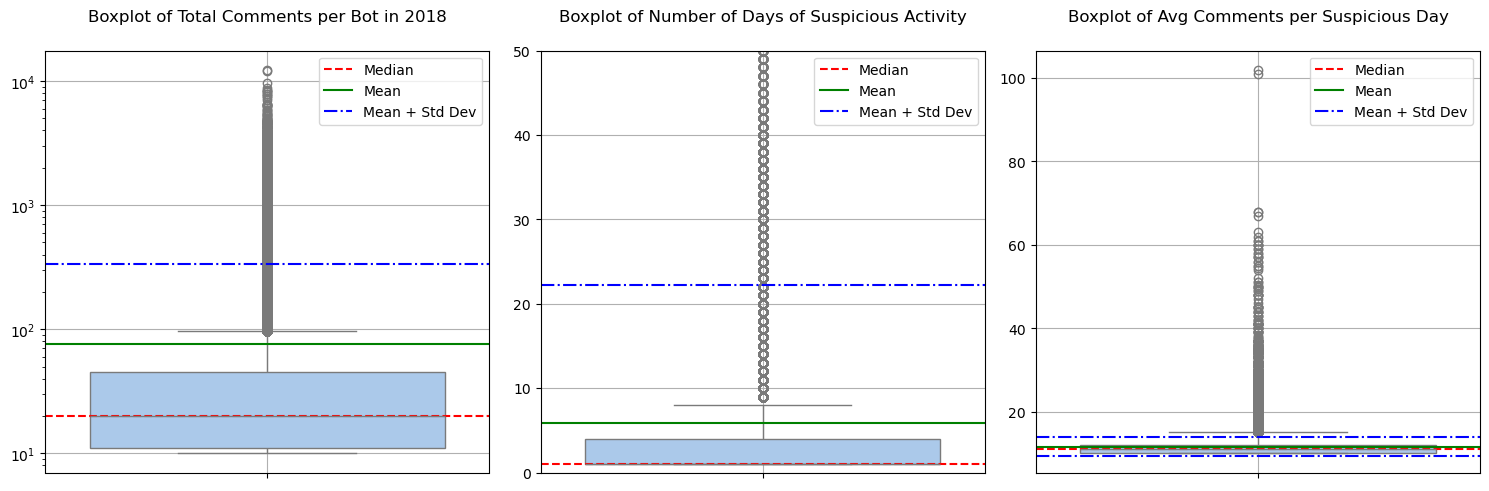

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the columns for plotting and adjust the display names
cols_to_plot = ['total_comments_year2018', 'suspicious_days', 'avg_comments_per_suspicious_day']
display_names = ['Total Comments per Bot in 2018', 'Number of Days of Suspicious Activity', 'Avg Comments per Suspicious Day']

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Iterate over columns and create boxplots
for i, (col, display_name) in enumerate(zip(cols_to_plot, display_names)):
    sns.boxplot(data=merged_data[col], ax=axes[i])
    
    # Set title with adjusted display name and remove axis labels
    axes[i].set_title(f'Boxplot of {display_name}', y=1.05)  # Title on top
    axes[i].set_xlabel("")  # Remove x-axis label
    axes[i].set_ylabel("")  # Remove y-axis label

    # Calculate median, mean, and standard deviation
    median = merged_data[col].median()
    mean = merged_data[col].mean()
    std_dev = merged_data[col].std()

    # Add median, mean, and standard deviation lines
    axes[i].axhline(median, color='red', linestyle='--', label='Median')
    axes[i].axhline(mean, color='green', linestyle='-', label='Mean')
    axes[i].axhline(mean + std_dev, color='blue', linestyle='-.', label='Mean + Std Dev')
    axes[i].axhline(mean - std_dev, color='blue', linestyle='-.')

    # Add legend
    axes[i].legend()

    # Apply log scale if needed
    if col == 'total_comments_year2018':
        axes[i].set_yscale('log')

    # Zoom in on suspicious_days
    if col == 'suspicious_days':
        axes[i].set_ylim(0, 50)

    # Add grid lines
    axes[i].grid(True)

# Customize color palette
sns.set_palette("pastel")

plt.tight_layout()
plt.show()



The stats on merged_data tell us that among the suspicious actions detected with our filter, we see that in average these users overtake the limit of 10 different videos commented 5.9 times in 2018. We have 25 % of the users which commented more than 4 times in 2018. This means some outliers pull the average up, for example the max is 357 days in the year were suspicious behavior was detected for a user. 

The max number of comment done in a year (still counting only days were it was above 10 different videos commented (remember how this dataset was built)) by a single user/author is 12328, while the average is 76.23 while only 25% of users are above a total number of comments in a year of 45. This means that the average number of comments is also biased by outliers which are very high. 

In the box plot grey circles are outliers. The boxplots reveal a right-skewed distribution for all three metrics. This indicates that a small number of users contribute a disproportionately large number of comments, experience extended periods of suspicious activity, and/or comment excessively during suspicious periods.


Now that we have the data for the number of comments per days we can put them in different categories. 


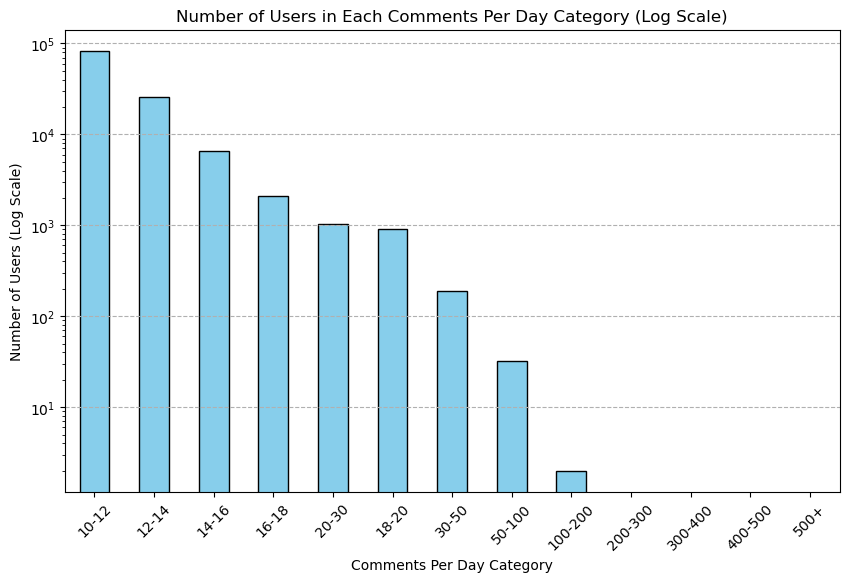

Counts of users in each comments per day category:
comments_per_day_category
10-12      83168
12-14      25943
14-16       6518
16-18       2106
20-30       1035
18-20        914
30-50        188
50-100        32
100-200        2
200-300        0
300-400        0
400-500        0
500+           0
Name: count, dtype: int64


In [32]:
# Define categories for the number of comments per day
bins = [10, 12, 14, 16, 18, 20, 30, 50, 100, 200, 300, 400, 500, 1000]
labels = ['10-12', '12-14', '14-16', '16-18', '18-20', '20-30', '30-50', '50-100', '100-200', '200-300', '300-400', '400-500', '500+']

# Fill the categories
merged_data['comments_per_day_category'] = pd.cut(merged_data['avg_comments_per_suspicious_day'], bins=bins, labels=labels, right=False)

# Plot the number of users in each category using a bar chart with logarithmic scale
category_counts = merged_data['comments_per_day_category'].value_counts()

# Plot the bar chart with logarithmic scale on the y-axis
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Number of Users in Each Comments Per Day Category (Log Scale)')
plt.xlabel('Comments Per Day Category')
plt.ylabel('Number of Users (Log Scale)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--')
plt.show()


print("Counts of users in each comments per day category:")
print(category_counts) 

The graph shows a right-skewed distribution, meaning that most users fall into the lower categories (10-12, 12-14, etc.), while fewer users are in the higher categories. This is just an other way to visualize the box plot from above of 'avg comments per suspicious day', it confirms our previous conclusion. 

Now we are ready to see if there is a link between having a higher number of 'avg comments per suspicious day' versus having a shorter 'lifetime', which could potentially mean that these bots were patched somehow. Many other reasons are possible but let's first see if we have a link. 

In [48]:
# Merge the DataFrames on 'author'
final_merge = merged_data.merge(bot_activity, on='author')

# Create the cross-tabulation 
category_combination_counts = pd.crosstab(final_merge['lifetime_category'], final_merge['comments_per_day_category'])

In [39]:
category_combination_counts.head(100)

comments_per_day_category,10-12,12-14,14-16,16-18,18-20,20-30,30-50,50-100,100-200
lifetime_category,,,,,,,,,
1 day,43776,10749,3267,1154,511,611,130,27,2
2-3 days,1527,696,270,101,60,74,13,0,0
3-5 days,1537,659,215,84,39,36,2,1,0
5-10 days,2845,1054,252,86,46,33,2,0,0
10-20 days,3662,1338,279,90,37,29,5,3,0
20-30 days,2896,1046,232,64,25,21,1,0,0
30-60 days,5964,2021,429,102,43,36,1,0,0
60-90 days,4055,1413,263,82,35,27,6,0,0
90-120 days,3171,1071,202,54,11,22,5,0,0


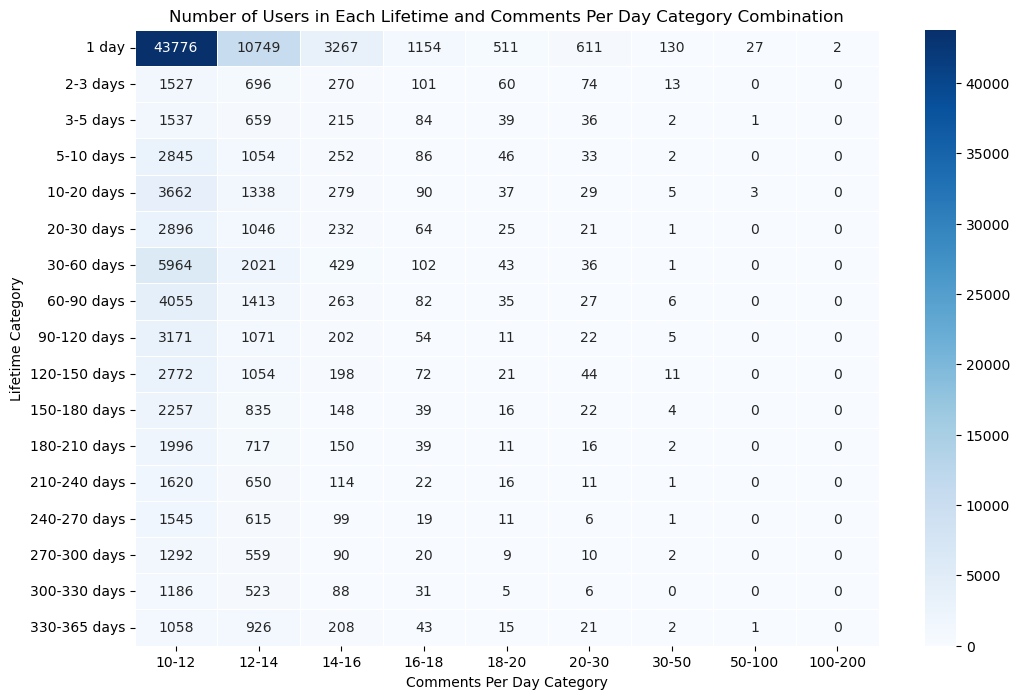

In [49]:
# Visualize the cross-tabulation as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(category_combination_counts, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title('Number of Users in Each Lifetime and Comments Per Day Category Combination')
plt.xlabel('Comments Per Day Category')
plt.ylabel('Lifetime Category')
plt.show()

The heatmap reveals a right-skewed distribution of bot behavior. Most bots exhibit short lifespans and low comment activity, while a smaller subset is characterized by longer lifespans and higher activity. This suggests that a significant portion of bots engage in short-lived, intense campaigns, while others maintain a more sustained, low-level presence.







***Tracks for the rest of the project:***

***Analyzing Seasonal Trends in Bot Activity***

In this analysis, we will aim to uncover potential seasonal patterns in bot activity based on the frequency of comments on videos. We’ll focus on:

**Weekly Trends**: Are there specific days of the week when bots are more active? For example, do they comment more frequently on weekends, like Saturdays?

**Seasonal Trends:**

*Activity by Season*: Are bots more or less active during certain times of the year? For instance, is there a drop in activity during the summer?

*Influence of Video Releases*: If we observe reduced activity in certain seasons, could it be related to fewer video releases during those times? This can be examined later in the project using the full dataset, which would include video release dates to help correlate bot activity with video availability.

*Variation in Bot Behavior Across Seasons*: Do different bots exhibit distinct seasonal behaviors? For example, some bots might be consistently active throughout the year, while others could show peaks and dips in specific seasons. Analyzing these patterns could help categorize bot behavior based on seasonality.

This approach should provide insights into both the temporal and behavioral aspects of bot activity across time.



***Another track :*** Check if suspicious users that we classified as bots (the one commenting on more than 10 videos per days) are focusing on a certain type of category, for instance on gaming ? Because from the dataset  1 we know already the repartition of comments from bots per category. But what types of bots do theses videos categories have in general ? 
For instance they could focus on commenting, on liking? What type of frequency? They activate everyday and comment videos, are they commenting the same videos over and over everyday ?) Are bots focusing on videos from a single channel ? 